# Introduction

The [dataset](https://www.kaggle.com/amananandrai/ag-news-classification-dataset) we'll be working with comes from Kaggle and contains news articles originating from 4 different class of news article with 30,000 training examples per class and 1900 training examples per class.

In this notebook we establish a computationally inexpensive baseline model in the form of an support vector machine that achieves 92% precision and 92% recall on the training dataset. We then review the size of the test dataset and show that the true performance of the model against unseen data is closer to 91% for both precision and recall by incorporating all of the availible training data into the model evaluation step.

# Packages and settings

In [ ]:
# For importing tabulated data
import pandas as pd
# For representing and operating on vectors and matracies
import numpy as np
# For mounting google drive as a virtual drive
from google.colab import drive
# For plotting data
import matplotlib.pyplot as plt

# Importing the dataset

In [ ]:
# Mount google drive as as a virtual drive
drive.mount('/content/drive')

# Read the dataset from google drive
train, test = pd.read_csv('/content/drive/My Drive/ag_news/train.csv'), pd.read_csv('/content/drive/My Drive/ag_news/test.csv')

# Combine the training and test set for initial inspection
dataset = pd.concat([train, test])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Show the dataset
dataset

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...
7596,2,Void is filled with Clement,With the supply of attractive pitching options...
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...


# Dataset exploration

Although we we know that there are an equal number of training and test examples per class, it is good practice to double check these facts as an imbalanced dataset will affect the way we train and evaluate the model. We can see from the barchart below that the class distribution across our training and test examples is indeed uniform.

Text(0.5, 1.0, 'Class distribution')

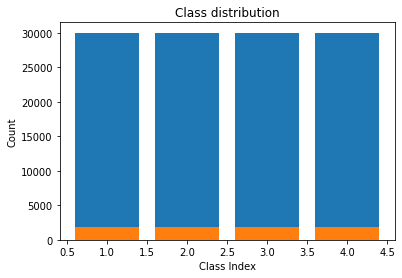

In [ ]:
# Plot the class distribution for the training set
ind, counts = np.unique(train['Class Index'].values, return_counts=True)
plt.bar(ind, counts)
plt.ylabel('Count')
plt.xlabel('Class Index')
plt.title('Class distribution')

# Plot the class distribution for the test set
ind, counts = np.unique(test['Class Index'].values, return_counts=True)
plt.bar(ind, counts)
plt.ylabel('Count')
plt.xlabel('Class Index')
plt.title('Class distribution')

It is also important to check for missing values in the dataset as we will need impute or remove these values

In [ ]:
# Check that there are no missing values from our data
np.sum(dataset.isna(), axis=0)

Class Index    0
Title          0
Description    0
dtype: int64

To check for anomolous data points it is desierable to look at the distribution of description lengths. We can see below that there are some descriptions that could be anomolous so let's look at them in more depth.

(0.0, 200.0)

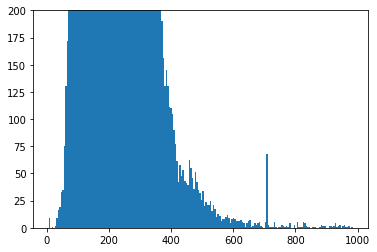

In [ ]:
description_lengths = dataset['Description'].apply(len).values
plt.hist(description_lengths, bins=200)
# Set the y limit of the graph in order to better understand the outliers in the distribution of description lengths
plt.ylim((0, 200))

We can see below that some news article descriptions of short length may not have been collected correctly. In the context of this problem, my biggest concern is that the article scraper may have picked a text element that was not related to the article (e.g. advert) instead of the description text. This could cause the model we'll train to learn a less accurate relationship between the class index and the description.

In this case, we check a small sample of 25 descriptions and titles and it seems that the descriptions are relevant to the title except where the description is missing, with value '#NAME?' instead.

In [ ]:
dataset[dataset['Description'].apply(len) < 50].sample(25)

,Class Index,Title,Description
21221,4,News: Nevadans to become first to use touch-sc...,The Associated Press By Rachel Konrad
18071,1,"Bush, Republicans Outpoll Kerry, Democrats on ...",Reuters - Although the election is not until
58808,4,News: Homeland Security signals effort to prom...,The Associated Press By Ted Bridis
26651,4,Barrage of Hurricanes May Just Be Florida Norm...,Reuters - Sorry Florida. This is normal.
86279,4,News.com Extra: Mozilla claims no Google brows...,Plus: Microsoft ready to launch search engine
1797,4,News: Governments slow off the mark to combat ...,The Associated Press By Robert Wielaard
18921,3,"ASEAN, Australia, N.Zealand See 2007 Pact (Reu...","Reuters - Southeast Asian nations, Australia and"
96114,4,UK looks at 'integrating' ID card with health ...,"To 'maximise benefits for patients', of course..."
59909,4,News: Computer crash linked to excessive heat ...,The Associated Press By Rachel Konrad
117505,4,News: Bush prepares for possible shutdown of G...,The Associated Press By Ted Bridis


On other side of the distribution we can see below that some news article descriptions of a longer length may not have been collected correctly either. Just as with the short descriptions we check a sample of 25. The long descriptions all seem relevant to the title so they can be left alone.

After digging into some of these full descriptions we can see that some of them contain html code that has not been removed by the scraper. If we were really looking to squeeze every ounce of performance out of our model then we could remove these from our text or we could add stopwords when vectorising the text. As it stands, the number of large and small texts make up a very small proportion of our dataset so it's not worth our time to address this problem at this stage in development.

In [ ]:
dataset[dataset['Description'].apply(len) > 600].sample(25)

,Class Index,Title,Description
82072,4,No More Books,\\I spent today packing up everything I own. ...
57215,4,Product Previews,F5 bolsters firewall family\The latest additio...
82070,4,More Election Response,\\More and more bloggers are waking to the new...
77692,3,When good vendors go bad,The most pervasive problem in running IT is no...
52085,1,Bush Follows Debate With Attack on Kerry,CLEVELAND - President Bush offered a sharp if ...
108623,4,U.S. Supreme Court to review cable Internet case,The U.S. Supreme Court has agreed to review an...
111618,4,Sprint: No comment on reported Nextel merger t...,WASHINGTON - Rumored merger talks between Spri...
104391,4,"Sony, IBM, Toshiba Give Details of 'Cell' Chip","TOKYO (Reuters) - IBM &lt;A HREF=""http://www...."
77444,4,"Study: 100,000 civilian deaths due to Iraq inv...","Today, the Lancet medical journal published a ..."
618,4,I Confess. I'm a Software Pirate.,\\I'm guilty. I'm a Software Pirate! Not jus...


Although we do not need to alter many of these descriptions as they seem relevant to their corresponding titles, we should replace missing descriptions that instead have the value of '#NAME?'. This is straightforward and will prevent our model from identifying a correlation between the presense of the "name" token and a given class when the model is being trained.

In [ ]:
# Replace description with empty string where the description is equal to #NAME?
# This should prevent the description from misinforming the model in these few cases
train.loc[train['Description'] == '#NAME?', 'Description'] = ''
test.loc[test['Description'] == '#NAME?', 'Description'] = ''
dataset.loc[dataset['Description'] == '#NAME?', 'Description'] = ''

We also check for anomolous data points by looking at the distribution of title lengths.

(0.0, 400.0)

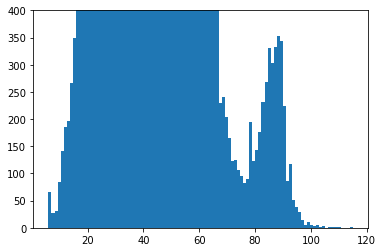

In [ ]:
title_lengths = dataset['Title'].apply(len).values
plt.hist(title_lengths, bins=100)
# Set the y limit of the graph in order to better understand the outliers in the distribution of description lengths
plt.ylim((0, 400))

We can see that there are a few anomalies where the title of the article is particularly short. These include a few rows where the title value is '#NAME?' or takes on the value of a website address. Again, it's not worth dealing with this issue immediately because this problem only affects a handful of training examples, however it's worth making a note of the problem in case we want to address it at a later date.

In [ ]:
print(len(dataset[dataset['Title'].apply(len) < 10]))
dataset[dataset['Title'].apply(len) < 10].sample(25)

123


,Class Index,Title,Description
48103,2,Footnotes,In the highest-scoring regulation game in Divi...
77530,4,Eye on IT,The Office of Government Commerce #39;s report...
18175,2,SI.com,ST. LOUIS (Ticker) -- Matt Morris tossed his s...
32624,2,SI.com,MINNEAPOLIS (Ticker) -- Johan Santana turned i...
42162,2,SI.com,LOS ANGELES (Ticker) -- The Los Angeles Dodger...
2595,2,SI.com,LOS ANGELES (Ticker) -- Wilson Alvarez continu...
42416,2,SI.com,"OAKLAND, California (Ticker) -- After playing ..."
102543,2,Kingpin,Hyping LeBron James as rightful inheritor of t...
75164,4,Pitcairn,"By now, most people will have heard of the rat..."
103080,3,Letters,"Placement of photo, headline confusing When I ..."


We can see on the right tail of the distribution of title lengths that the titles look okay so there's nothing to be done.

In [ ]:
dataset[dataset['Title'].apply(len) > 90].sample(25)

,Class Index,Title,Description
11362,2,Quinn relieved that goalie Ed Belfour #39;s ba...,TORONTO (CP) - Maple Leafs goaltender Ed Belfo...
91400,1,"Fingerprints, photographs begin at U.S. border...",Canadian Press - (AP) - Bridges to Mexico in t...
43759,1,Homicide rate fell to lowest level in more tha...,Canadian Press - OTTAWA (CP) - The national ho...
95745,3,Merck #39;s Vioxx Withdrawal Illustrates Power...,Merck amp; Co. withdrew the popular drug Viox...
88764,4,South Korea #39;s LG to file suit to nullify M...,SEOUL : South Korea #39;s LG Electronics will ...
55443,4,AT amp;T #39;s Gambit: Relying On Automation T...,AT amp;T #39;s top IT exec says automation tha...
100757,1,Ex-premier Bouchard still being treated for pe...,Canadian Press - MONTREAL (CP) - Ex-premier Lu...
87109,1,Union #39;Cautiously Optimistic #39; About La...,A consortium of major industrial nations has n...
70064,1,Helicopters evacuate Japanese villagers after ...,"Canadian Press - OJIYA, Japan (AP) - Military ..."
113666,4,NASA #39;s O #39;Keefe to Resign; Ex-Missile D...,NASA Administrator Sean O #39;Keefe will resig...


In [ ]:
# Replace title with empty string where the title is equal to #NAME?
# This should prevent the title from misinforming the model in these few cases
train.loc[train['Title'] == '#NAME?', 'Title'] = ''
test.loc[test['Title'] == '#NAME?', 'Title'] = ''
dataset.loc[dataset['Title'] == '#NAME?', 'Title'] = ''

The provided test set is quite small, making up just 6% of the availible data. While it is certainly advantageous to train on a larger proportion of the available data we also want to get an accurate understanding of how the model will generalise to unseen data. A smaller test set means a higher probability that the model's recorded performance against the test set does not accurately represent the true performance against unseen data. Initially we'll evaluate our model against this test set but then we'll improve upon this evaluation method by incorporating more of our data into the model evaluation step.

In [ ]:
print(f'The test set makes up {round(len(test) / (len(train) + len(test)) * 100 , 2)}% of the availible training data.')

The test set makes up 5.96% of the availible training data.


# Feature selection

We create features from unigrams, bigrams and trigrams. This increases the number of features drastically which in-turn raises the risk of overfitting the model. However, given our large dataset and simplified decision boundary this choice of features should improve performance on the test set instead of hindering it. We make use of both the titles and descriptions by feeding features from both into our model.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vec_title = CountVectorizer(ngram_range=(1, 3)).fit(train['Title'].values)
count_vec_desc = CountVectorizer(ngram_range=(1, 3)).fit(train['Description'].values)

# Vectorise the training data
X_train_title_counts = count_vec_title.transform(train['Title'].values)
X_train_desc_counts = count_vec_desc.transform(train['Description'].values)

print(X_train_title_counts.shape)
print(X_train_desc_counts.shape)

(120000, 840727)
(120000, 3017395)


In [ ]:
# We use tf-idf to encode the rarity of a feature within it's given text and against the corpus as a whole
from sklearn.feature_extraction.text import TfidfTransformer
tf_title_transformer = TfidfTransformer().fit(X_train_title_counts)
tf_desc_transformer = TfidfTransformer().fit(X_train_desc_counts)

X_train_title_tf = tf_title_transformer.transform(X_train_title_counts)
X_train_desc_tf = tf_desc_transformer.transform(X_train_desc_counts)

print(X_train_title_tf.shape)
print(X_train_desc_tf.shape)

(120000, 840727)
(120000, 3017395)


In [ ]:
# Combine the sparse matracies from the description and the title into a single matrix
from scipy import sparse as sp
X = sp.hstack([X_train_title_tf, X_train_desc_tf])
print(X.shape)

(120000, 3858122)


In [ ]:
# Get the correct label for each training example
y_train = train['Class Index'].values

# Model selection

[This paper](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf) shows a comparison of several different models for text classification.
It shows that Support Vector Machine (SVM) is better suited for full-length content whereas Multinomial Naive Bayes (MNB) performs better on snippets.
The paper also shows that MNB is better than SVM/Logistic Regression when there are few training examples. As there are a large number of training examples per class, a Support Vector Machine is well suited to modelling this dataset.

In particular we use the SVM implementation from sklearn as sklearn is a reputable, open-source machine learning library with excellent documentation and rich community support on stack overflow.

It is also worth mentioning that this implementation of the SVM does not support GPU acceleration and that we could  receive a significant speedup by instead using one that does.

The SVM model has several parameters. One such parameter that affects the decision boundary as well as training time is the choice of kernel. It would be great to use the rbf kernal as this typically gives great performance; it can find correlations between features to create a better decision boundary. The trade-off with the use of the rbf kernel is that it scales poorly with the number of training examples. For this reason we use the linear kernel and try to feed in some of the local corelations between tokens by encoding bigrams and trigrams.

In [ ]:
# Train a baseline model
from sklearn.svm import LinearSVC
import time

start_time = time.time()
clf = LinearSVC().fit(X, y_train)
print(f'Model trained in {round(time.time() - start_time, 2)}s.')

Model trained in 26.4s.


In [ ]:
# One-hot encode the test data
X_test_title_counts = count_vec_title.transform(test['Title'].values)
X_test_desc_counts = count_vec_desc.transform(test['Description'].values)

X_test_title_tf = tf_title_transformer.transform(X_test_title_counts)
X_test_desc_tf = tf_desc_transformer.transform(X_test_desc_counts)

# Combine the sparse matracies from the description and the title into a single matrix
from scipy import sparse as sp
X2 = sp.hstack([X_test_title_tf, X_test_desc_tf])
print(X.shape)

# Get the correct label for each test example
y_test = test['Class Index'].values

# Get predictions for the test set 
y_pred = clf.predict(X2)

(120000, 3858122)


# Model evaluation

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))
print(f'Average precision: {round(metrics.precision_score(y_test, y_pred, average="macro") * 100, 2)}%')
print(f'Average recall: {round(metrics.recall_score(y_test, y_pred, average="macro") * 100, 2)}%')

              precision    recall  f1-score   support

           1       0.93      0.92      0.93      1900
           2       0.95      0.99      0.97      1900
           3       0.90      0.89      0.90      1900
           4       0.90      0.91      0.91      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600

Average precision: 92.38%
Average recall: 92.41%


We can see that our baseline model achieves a very good performance on the test set with precision=92% and a recall=92%. These metrics would be especially useful when assessing the performance of the model that was trained on an imbalanced training set.

We can also see that the model performs better on class 1 and 2 while comparitively struggling with class 3 and 4. This is very useful to keep in mind when we look at where our time will be best spent improving our performance on this classification task.

As the test set is small, it would be great to get a more reliable measure of the model's performance by using k-fold cross-validation to incorporate our entire dataset in testing the model. As the model is relatively quick to train, the computation penalty of this method is negligible but for larger models such as deep learning models, the computation penalty will be significant.

In [ ]:
count_vec_title = CountVectorizer(ngram_range=(1, 3)).fit(dataset['Title'].values)
count_vec_desc = CountVectorizer(ngram_range=(1, 3)).fit(dataset['Description'].values)

# One-hot encode the training data
X_title_counts = count_vec_title.transform(dataset['Title'].values)
X_desc_counts = count_vec_desc.transform(dataset['Description'].values)

print(X_title_counts.shape)
print(X_desc_counts.shape)

(127600, 881613)
(127600, 3155161)


In [ ]:
# We use tf-idf to encode the rarity of a feature within it's given text and against the corpus as a whole
from sklearn.feature_extraction.text import TfidfTransformer
tf_title_transformer = TfidfTransformer().fit(X_title_counts)
tf_desc_transformer = TfidfTransformer().fit(X_desc_counts)

X_title_tf = tf_title_transformer.transform(X_title_counts)
X_desc_tf = tf_desc_transformer.transform(X_desc_counts)

print(X_title_tf.shape)
print(X_desc_tf.shape)

(127600, 881613)
(127600, 3155161)


In [ ]:
# Combine the sparse matracies from the description and the title into a single matrix
from scipy import sparse as sp
X3 = sp.hstack([X_title_tf, X_desc_tf])
print(X.shape)

(120000, 3858122)


In [ ]:
# Get the correct label for each test example
y = dataset['Class Index'].values

In [ ]:
from sklearn.model_selection import cross_validate
k = 20
clf = LinearSVC()

start_time = time.time()
scores = cross_validate(clf, X3, y, cv=k, scoring=['precision_macro', 'recall_macro'])

print(f'Total fit time:{round(scores["fit_time"].sum(), 2)}s')
print(f'Mean fit time:{round(scores["fit_time"].mean(), 2)}s')
print(f'{round(scores["test_precision_macro"].mean() * 100, 2)}% precision with a standard deviation of {round(scores["test_precision_macro"].std(), 2)}')
print(f'{round(scores["test_recall_macro"].mean() * 100, 2)}% recall with a standard deviation of {round(scores["test_recall_macro"].std(), 2)}')

Total fit time:516.77s
Mean fit time:25.84s
91.28% precision with a standard deviation of 0.01
91.28% recall with a standard deviation of 0.01


We can see that the time taken for 20-fold cross-validation is roughly 20x the time taken to train the model once. This works out to be just under 10 minutes which fits well within the usual time constraints.

More imoprtantly, we can see that we previously overestimated the precision and recall of our model by evaluating on a small test set. The precision and recall are actually about 1% lower in each case.

# Discussion

The model that we've trained provides a very good baseline for this dataset. We have achieved a relatively high precision and recall on the dataset achieving above 90% in both metrics, and we can feel confident in these statistics because we evaluated them using 20-fold cross-validation.

At this level of precision we'll make roughly 1 error every 10 decisions we make which is a relatively high error rate. Improving our model's precision by just 5% would would cut this error rate in half.

This is a lightweight model that can be run without a graphics card and with a short time for classification. This is particularly desirable when there is a lack of resources available or when we are under time constraints.

To improve the precision and recall of the model further we may look at tuning the regularisation parameter of the SVM model. Regularisation helps to improve the performance on unseen data by preventing model overfitting. This is unlikely to improve the performance of our model too drastically as we are already using a simplified decision boundary. It is worth pointing out that, if we should choose to do this, we should split our dataset into a training, test and validation set for this step so that we do not introduce bias into our model. We would then train and evaluate for several different sets of parameter values on the training and test sets before finally evaluating the true performance on the validation set. 

To further improve performance on this dataset we could look at leveraging a more complicated model such as Google's pre-trained Bert. We can feel assured that a more complicated model is unlikely to overfit as we have a sizeable training dataset. This model would allow us to transfer existing knowledge captured in the weights of the model. Additionally this deep learning model is designed to capture correlations between words and sentences in text to better understand context and word sense. The trade off with this model is that we would require a GPU to train and evaluate the model, and the model is likely to take some time to train and evaluate especialy if we use k-fold cross-validation to get a more accurate measure of the models performance as we have done above.